# Análisis Exploratorio: San Francisco Bay Bike Rental

https://www.kaggle.com/benhamner/sf-bay-area-bike-share

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trip_meta = pd.read_csv('data/trip.csv')
weather_meta = pd.read_csv('data/weather.csv')

In [3]:
pd.options.mode.chained_assignment = None

### Convierto las fechas a datetime

In [4]:
trip_meta['start_date'] = pd.to_datetime(trip_meta['start_date'])

In [5]:
trip_meta['end_date'] = pd.to_datetime(trip_meta['end_date'])

In [6]:
import datetime
from datetime import date,time

In [7]:
#Saco los horarios de las fechas para analizar primero los viajes que son realizados durante el mismo dia
trip_meta['start_date2'] = trip_meta.start_date.apply(lambda x: datetime.datetime(x.year, x.month, x.day,0,0))
trip_meta['end_date2'] = trip_meta.end_date.apply(lambda x: datetime.datetime(x.year, x.month, x.day,0,0))

In [10]:
trip_meta.duration = trip_meta.duration.apply(lambda x: x/60.0)

In [11]:
trip_meta.rename(columns={'duration':'duration(min)'},inplace=True)

In [12]:
trip_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 13 columns):
id                    669959 non-null int64
duration(min)         669959 non-null float64
start_date            669959 non-null datetime64[ns]
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null datetime64[ns]
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
start_date2           669959 non-null datetime64[ns]
end_date2             669959 non-null datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(4), object(4)
memory usage: 66.4+ MB


In [24]:
same_day = trip_meta.loc[trip_meta.start_date2 == trip_meta.end_date2,['id','duration(min)','start_date2','end_date2','start_station_name','start_station_id','end_station_name','end_station_id']]

In [25]:
same_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667860 entries, 0 to 669958
Data columns (total 8 columns):
id                    667860 non-null int64
duration(min)         667860 non-null float64
start_date2           667860 non-null datetime64[ns]
end_date2             667860 non-null datetime64[ns]
start_station_name    667860 non-null object
start_station_id      667860 non-null int64
end_station_name      667860 non-null object
end_station_id        667860 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 45.9+ MB


### Son 2099 los viajes que duran mas de 1 dia

In [26]:
print len(trip_meta) - len(same_day)

2099


In [27]:
same_day.describe()

,id,duration(min),start_station_id,end_station_id
count,667860.000000,667860.000000,667860.000000,667860.00000
mean,460563.297664,14.936870,57.877699,57.85896
std,264565.577399,36.510578,17.088461,17.17720
min,4069.000000,1.000000,2.000000,2.00000
25%,231317.750000,5.733333,50.000000,50.00000
50%,459550.000000,8.600000,62.000000,62.00000
75%,692844.250000,12.550000,70.000000,70.00000
max,913460.000000,1390.150000,84.000000,84.00000


### Filtro los viajes que duran menos de 5 minutos

In [28]:
trips_longer = same_day.loc[same_day['duration(min)'] > 5,:]

In [29]:
trips_longer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542405 entries, 100 to 669958
Data columns (total 8 columns):
id                    542405 non-null int64
duration(min)         542405 non-null float64
start_date2           542405 non-null datetime64[ns]
end_date2             542405 non-null datetime64[ns]
start_station_name    542405 non-null object
start_station_id      542405 non-null int64
end_station_name      542405 non-null object
end_station_id        542405 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 37.2+ MB


### Son 125455 los viajes que duran menos de 5 min

In [30]:
print len(same_day) - len(trips_longer)

125455


In [31]:
# Convierto a datetime la fecha en el DF weather
weather_meta['date'] = pd.to_datetime(weather_meta['date'])

# Viajes segun las condiciones climaticas

### Analizo la cantidad de viajes segun la temperatura

In [32]:
temperatures = weather_meta[['date','max_temperature_f','mean_temperature_f','min_temperature_f']]

In [33]:
# Paso la temperatura a Celsius
temperatures.max_temperature_f = temperatures.max_temperature_f.apply(lambda x: (x-32) / 1.8)
temperatures.mean_temperature_f = temperatures.mean_temperature_f.apply(lambda x: (x-32) / 1.8)
temperatures.min_temperature_f = temperatures.min_temperature_f.apply(lambda x: (x-32) / 1.8)

In [34]:
temperatures.rename(
    columns={'max_temperature_f':'max_temperature_c','mean_temperature_f':'mean_temperature_c','min_temperature_f':'min_temperature_c'},inplace=True)

In [35]:
temperatures_avg = temperatures.groupby('date').mean()
temperatures_avg = pd.DataFrame(temperatures_avg.to_records())

In [36]:
final = trips_longer[['id', 'duration(min)', 'start_date2', 'start_station_name','end_station_name']]
final.rename(columns={'start_date2':'date'},inplace=True)

In [37]:
date_duration = final.loc[:,['duration(min)','date']].groupby('date').agg([np.size])
date_duration = pd.DataFrame(date_duration.to_records())
date_duration.columns=['date','# trips']

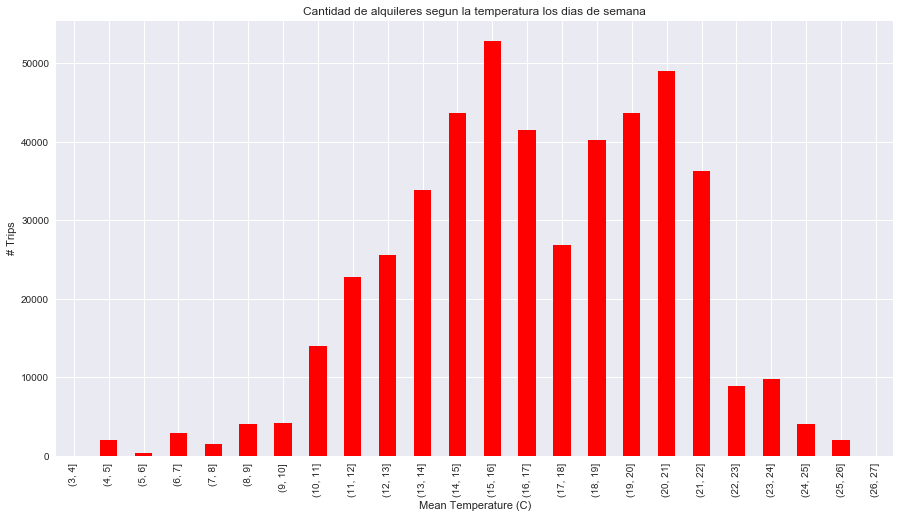

In [38]:
duration_temperature = pd.merge(date_duration,temperatures_avg,how='inner',on='date')
duration_temperature['weekday'] = duration_temperature.date.apply(lambda x: x.weekday())
duration_temperature_weekdays = duration_temperature\
                        .loc[(duration_temperature.weekday != 5) & (duration_temperature.weekday != 6),:]

duration_temperature_weekdays = duration_temperature_weekdays\
                        [['# trips','date','max_temperature_c','mean_temperature_c','min_temperature_c']]
    
trips_temperature = duration_temperature_weekdays.\
                groupby(pd.cut(duration_temperature_weekdays['mean_temperature_c'], np.arange(3,28))).sum()

f = plt.figure()
ax = trips_temperature['# trips'].plot.bar(figsize=(15,8),colormap='autumn',layout=('# trips','Mean Temperature (C)'), ax=f.gca())
ax.set_ylabel('# Trips');
ax.set_xlabel('Mean Temperature (C)');
plt.title('Cantidad de alquileres segun la temperatura los dias de semana')
plt.show()

# --------------------------------------------------------------------------------------------------

### Alquiler de bicicletas segun la lluvia, los dias de semana

In [39]:
precipitation = weather_meta[['date','precipitation_inches']]

In [40]:
precipitation.columns = ['date','inches']

In [41]:
precipitation = precipitation.loc[precipitation.inches != 'T',:]
precipitation.inches = pd.to_numeric(precipitation.inches)

In [42]:
precipitation = precipitation.groupby('date').mean()
precipitation = pd.DataFrame(precipitation.to_records())

In [43]:
precipitation_trips = pd.merge(date_duration,precipitation,how='inner',on='date')

In [44]:
precipitation_trips = precipitation_trips[['# trips','date','inches']]

In [45]:
precipitation_trips['weekday'] = precipitation_trips.date.apply(lambda x: x.weekday())
precipitation_trips = precipitation_trips.loc[(precipitation_trips.weekday != 5) & (precipitation_trips.weekday != 6),:]

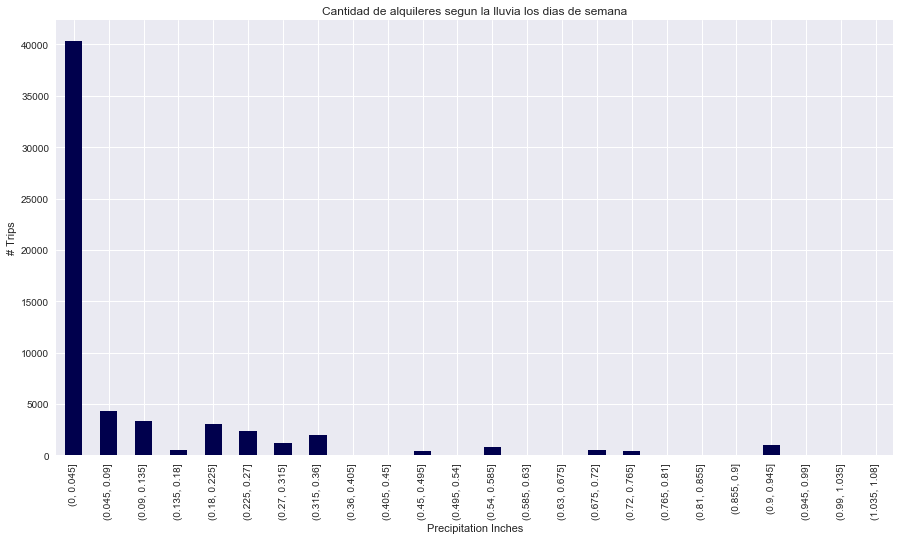

In [46]:
precipitation_trips_plot = precipitation_trips.\
                groupby(pd.cut(precipitation_trips['inches'], np.arange(0, 1.1, 0.045))).sum()

f = plt.figure()
ax = precipitation_trips_plot['# trips'].plot.bar(figsize=(15,8),colormap='seismic',ax=f.gca())
ax.set_ylabel('# Trips');
ax.set_xlabel('Precipitation Inches');
plt.title('Cantidad de alquileres segun la lluvia los dias de semana')
plt.show()

# ------------------------------------------------------------------------------------------------------

### Viajes segun la nubosidad


In [47]:
cloudy = weather_meta[['date','cloud_cover']].groupby('date').mean()
cloudy_avg = pd.DataFrame(cloudy.to_records())

In [48]:
cloudy_stats = pd.merge(final,cloudy_avg,how='inner',on='date')

In [49]:
cloudy_stats.describe()

,id,duration(min),cloud_cover
count,542405.000000,542405.000000,542405.000000
mean,459580.354071,17.521651,2.701077
std,265849.505073,40.069983,1.900025
min,4073.000000,5.016667,0.000000
25%,229821.000000,7.316667,1.200000
50%,457334.000000,9.833333,2.600000
75%,693665.000000,13.733333,4.000000
max,913460.000000,1390.150000,8.000000


### Porcentaje de viajes en dias de nubosidad elevada


In [50]:
total_cloudy = cloudy_stats.count()
travels_cloudy = cloudy_stats.loc[cloudy_stats.cloud_cover > 4].count() / cloudy_stats.count()
print travels_cloudy * 100

id                    22.88917
duration(min)         22.88917
date                  22.88917
start_station_name    22.88917
end_station_name      22.88917
cloud_cover           22.88917
dtype: float64


### Duracion de viajes en dias de nubosidad elevada

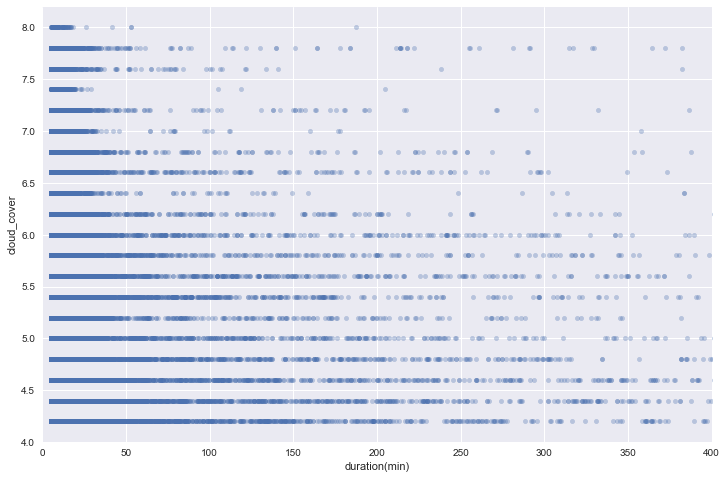

In [51]:
travels_cloudy = cloudy_stats.loc[cloudy_stats.cloud_cover > 4]
fig = plt.figure()
ax = plt.subplot(111)
travels_cloudy.plot.scatter('duration(min)','cloud_cover',alpha=0.32,figsize=(12,8),ax=ax);
ax.set_xlim(0,400);

### Duracion de viajes vs nubocidad

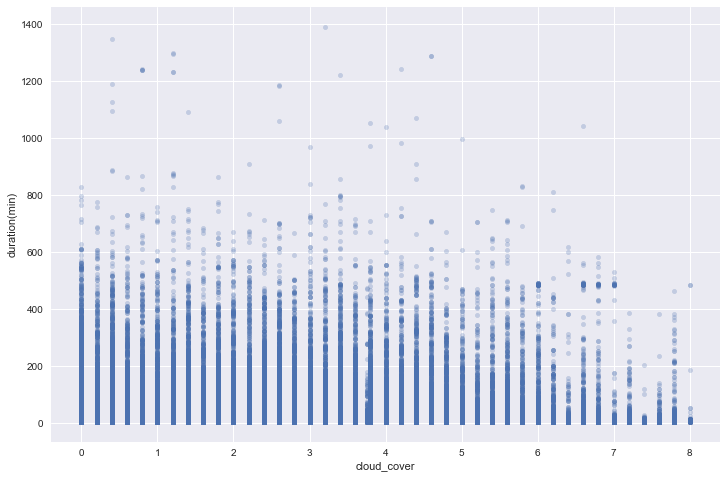

In [52]:
#Scatter plot: cloud cover vs duration
cloudy_stats.plot.scatter('cloud_cover','duration(min)',alpha=0.25,figsize=(12,8));

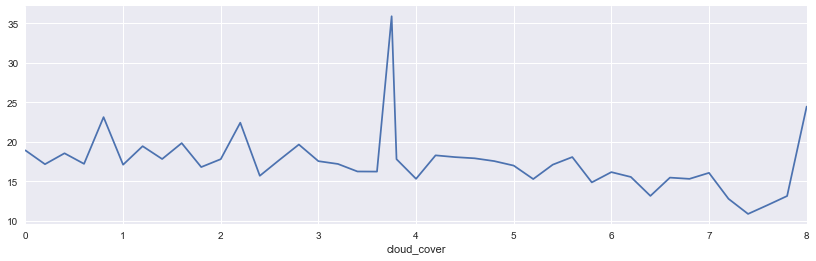

In [53]:
# Cloud cover vs duration
cloudy_stats.groupby('cloud_cover').mean()['duration(min)'].plot(figsize=(14,4));

# Alquiler de bicicletas por hora

In [54]:
trip_meta['hour'] = trip_meta.start_date.apply(lambda x: x.hour)

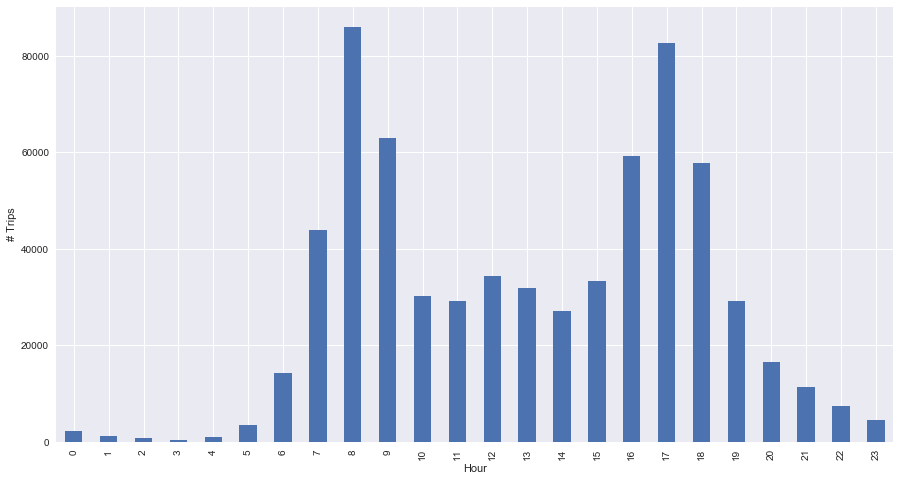

In [55]:
ax = trip_meta.groupby('hour').size().plot(kind='bar',figsize=(15,8))
ax.set_ylabel('# Trips')
ax.set_xlabel('Hour')

# Cantidad de alquileres por dia y la duracion promedio de los mismos.

In [56]:
dif_day_trips = final[['duration(min)','date']]
dif_day_trips['weekday'] = dif_day_trips.date.apply(lambda x: x.weekday())

In [57]:
dia = {
    0:'Lunes',
    1:'Martes',
    2:'Miercoles',
    3:'Jueves',
    4:'Viernes',
    5:'Sabado',
    6:'Domingo'
}

In [58]:
dif_day_trips['weekday'] = dif_day_trips['weekday'].apply(lambda x: dia[x])

In [59]:
dif_day_trips = dif_day_trips[['duration(min)','weekday']]

In [60]:
trips_by_day = dif_day_trips.groupby('weekday').agg([np.mean,np.size])
trips_by_day

duration(min)         
                   mean     size
weekday                         
Domingo       36.838362  33548.0
Jueves        14.532981  95503.0
Lunes         14.507142  92669.0
Martes        14.021545  97411.0
Miercoles     14.322358  96160.0
Sabado        34.903722  38940.0
Viernes       16.256842  88174.0

In [61]:
dif_day_trips_cant = pd.DataFrame(trips_by_day.to_records())
dif_day_trips_cant.columns = ['weekday','avg trip','trips']
dif_day_trips_avg = dif_day_trips_cant[['weekday','avg trip']]
dif_day_trips_cant = dif_day_trips_cant[['weekday','trips']]

## Cantidad de alquileres por dia

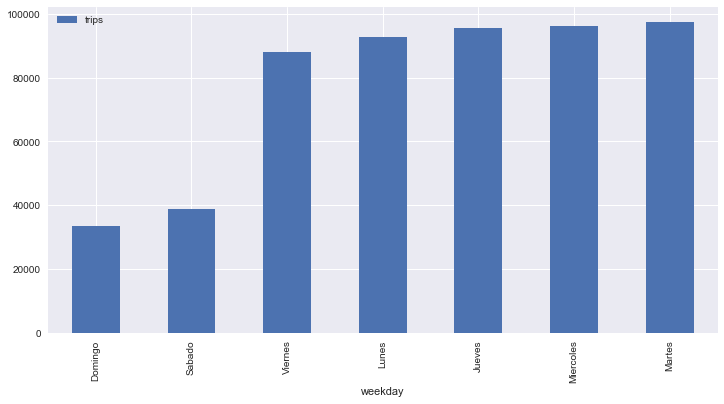

In [93]:
dif_day_trips_cant.sort_values('trips').plot('weekday','trips',kind='bar',figsize=(12,6))

## Duracion promedio de los alquileres por dia

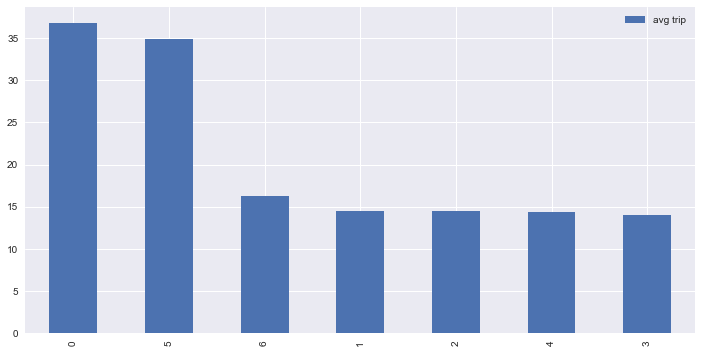

In [63]:
dif_day_trips_avg.sort_values('avg trip',ascending=False).plot(kind='bar',figsize=(12,6))

# Estaciones más populares

In [64]:
station_stats = pd.concat([trip_meta['start_station_name'], trip_meta['end_station_name']])
station_stats.head()

0    South Van Ness at Market
1          San Jose City Hall
2     Mountain View City Hall
3          San Jose City Hall
4    South Van Ness at Market
dtype: object

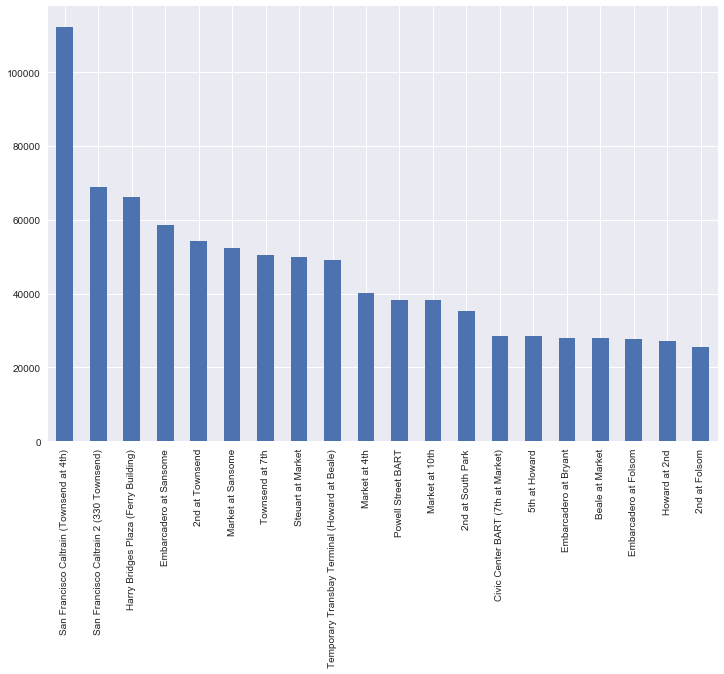

In [65]:
# TOP 20 Estaciones mas populares
station_stats_plot = station_stats.value_counts().head(20).plot(kind='bar',rot=90,figsize=(12,8));
station_stats_plot

## Estaciones más populares por día

In [67]:
popular_stations = trip_meta[['start_date','start_station_name','duration(min)']]

In [68]:
# Filtro los viajes que duran menos de 5 minutos
popular_stations = popular_stations.loc[popular_stations['duration(min)'] > 5,:]
popular_stations.head()

,start_date,start_station_name,duration(min)
100,2013-08-29 17:22:00,Civic Center BART (7th at Market),5.083333
101,2013-08-29 12:12:00,University and Emerson,5.116667
102,2013-08-29 11:53:00,San Francisco City Hall,5.150000
103,2013-08-29 11:58:00,Powell Street BART,5.150000
104,2013-08-29 18:09:00,2nd at Townsend,5.150000


In [69]:
popular_stations.rename(columns={'start_date':'date','start_station_name':'station'},inplace=True)

In [70]:
popular_stations['weekday'] = popular_stations.date.apply(lambda x: x.weekday())

In [71]:
popular_stations['weekday'] = popular_stations['weekday'].apply(lambda x: dia[x])

In [73]:
popular_stations = popular_stations[['station','duration(min)','weekday']]

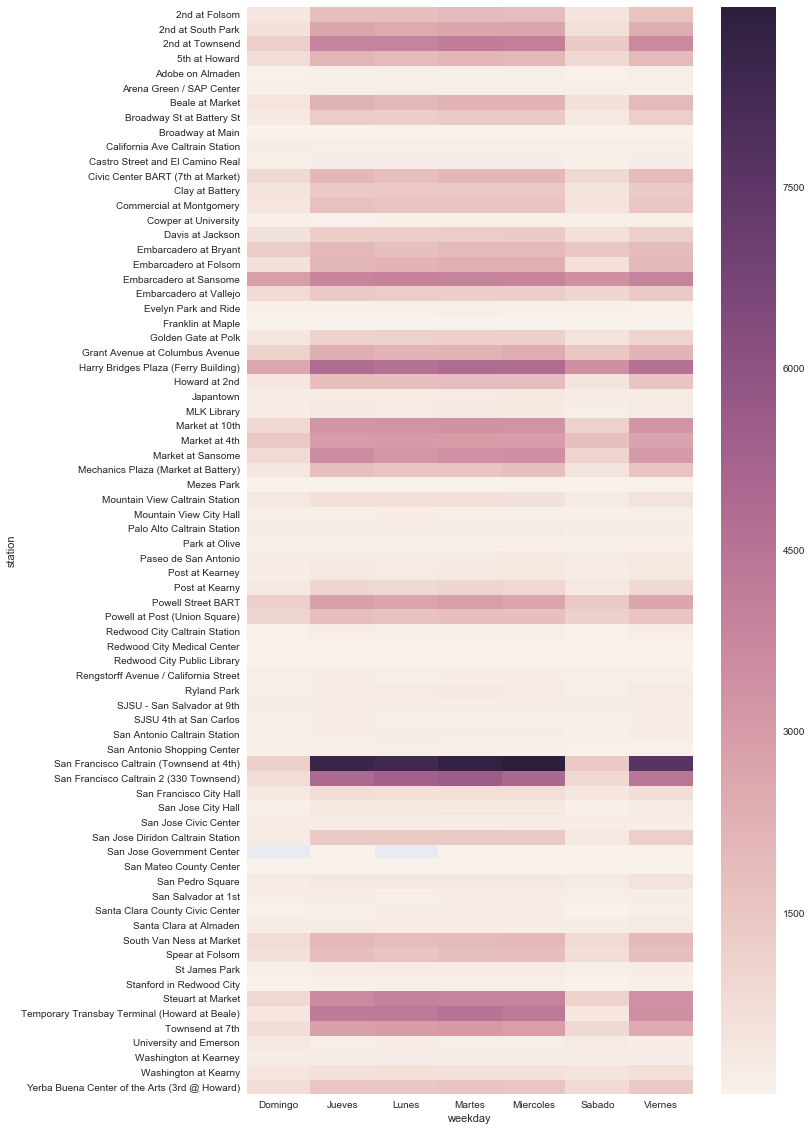

In [74]:
popular_stations = popular_stations.groupby(['station','weekday']).agg([np.size])
popular_stations = pd.DataFrame(popular_stations.to_records())
popular_stations.columns = ['station','weekday','trips']
popular_stations = pd.pivot_table(popular_stations,values='trips',columns='weekday',index='station')
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(popular_stations)

## Cual de las estaciones nuevas fue la mas usada?

In [75]:
station_meta = pd.read_csv('data/station.csv')
station_meta['installation_date'] = pd.to_datetime(station_meta['installation_date'])
station_meta.tail()

,id,name,lat,long,dock_count,city,installation_date
65,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,2013-08-25
66,80,Santa Clara County Civic Center,37.352601,-121.905733,15,San Jose,2013-12-31
67,82,Broadway St at Battery St,37.798541,-122.400862,15,San Francisco,2014-01-22
68,83,Mezes Park,37.491269,-122.236234,15,Redwood City,2014-02-20
69,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09


In [76]:
last_year = datetime.datetime(2014,1,1)
new_stations = station_meta.loc[station_meta.installation_date >= last_year]

In [77]:
final.rename(columns={'start_station_name':'name'},inplace=True)
new_stations = pd.merge(final,new_stations,how='inner',on='name')
new_stations.tail()

,id_x,duration(min),date,name,end_station_name,id_y,lat,long,dock_count,city,installation_date
9010,433758,7.650000,2014-09-02,Ryland Park,Santa Clara County Civic Center,84,37.342725,-121.895617,15,San Jose,2014-04-09
9011,433727,6.816667,2014-09-02,Ryland Park,San Jose Civic Center,84,37.342725,-121.895617,15,San Jose,2014-04-09
9012,433653,11.600000,2014-09-02,Ryland Park,San Jose Diridon Caltrain Station,84,37.342725,-121.895617,15,San Jose,2014-04-09
9013,433552,10.933333,2014-09-02,Ryland Park,San Jose Diridon Caltrain Station,84,37.342725,-121.895617,15,San Jose,2014-04-09
9014,433003,8.633333,2014-09-01,Ryland Park,San Jose Civic Center,84,37.342725,-121.895617,15,San Jose,2014-04-09


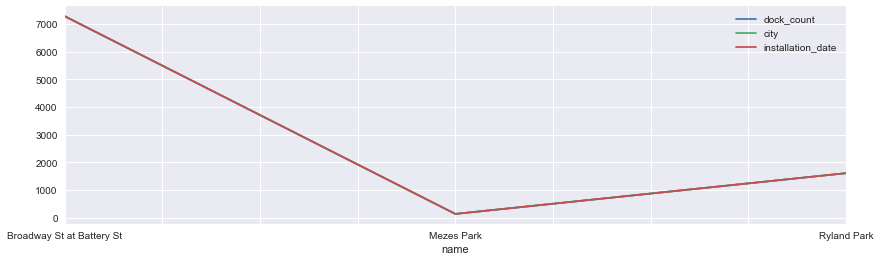

In [78]:
popular_new_stations = new_stations[['name','dock_count','city','installation_date']]\
                .groupby('name').count().plot(figsize=(14,4));

In [79]:
# Quiero ver cual es el promedio de docks en cada estacion
station_meta['dock_count'].mean()

17.65714285714286

In [80]:
# Ahora quiero ver que pasa en Broadway St at Battery (de las nuevas, la mas usada)
station_meta.loc[station_meta.name == 'Broadway St at Battery St']['dock_count']

67    15
Name: dock_count, dtype: int64

## Cual es la ciudad que mas usa el servicio?

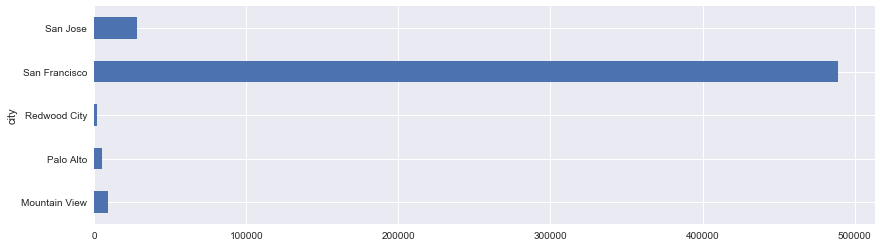

In [81]:
popular_city = pd.merge(final,station_meta,how='inner',on='name')
popular_city.groupby('city').count()['id_x'].plot(kind='barh',figsize=(14,4));

# -------------------------------------------------------------------------------------------------------- 

# Viajes segun el tipo de subscripcion

In [86]:
subscription_trips = trip_meta.loc[:,['duration(min)','subscription_type']]
subscription_trips = subscription_trips.groupby('subscription_type').agg([np.mean,np.size])
subscription_trips

duration(min)          
                           mean      size
subscription_type                        
Customer              65.862689  103213.0
Subscriber             9.834148  566746.0

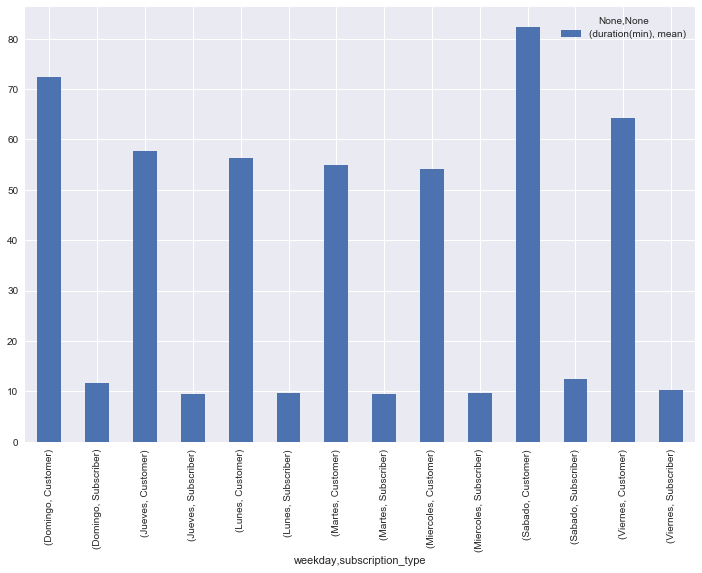

In [88]:
subscription_trips2 = trip_meta.loc[:,['duration(min)','subscription_type','start_date2']]
subscription_trips2['weekday'] = subscription_trips2['start_date2'].apply(lambda x: x.weekday())
subscription_trips2['weekday'] = subscription_trips2['weekday'].apply(lambda x: dia[x])
subscription_trips2.loc[:,['duration(min)','subscription_type','weekday']].groupby(['weekday','subscription_type']).agg([np.mean]).plot.bar(figsize=(12,8))

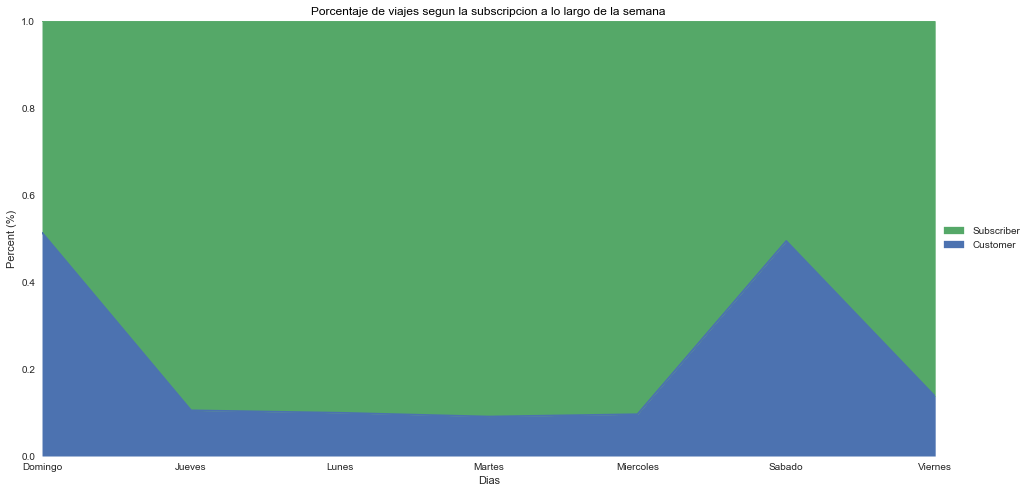

In [89]:
subscription_trips3 = trip_meta.loc[:,['duration(min)','subscription_type','start_date2']]
subscription_trips3['weekday'] = subscription_trips3['start_date2'].apply(lambda x: x.weekday())
subscription_trips3['weekday'] = subscription_trips3['weekday'].apply(lambda x: dia[x])
subscription_trips3 = subscription_trips3.loc[:,['duration(min)','subscription_type','weekday']].groupby(['weekday','subscription_type']).agg([np.size])
subscription_trips3 = pd.DataFrame(subscription_trips3.to_records())
subscription_trips3.columns = ['weekday','subscription_type','trips']
subscription_trips3 = pd.pivot_table(subscription_trips3,values='trips',columns='subscription_type',index='weekday')
subscription_trips3 = subscription_trips3.divide(subscription_trips3.sum(axis=1),axis=0)

f = plt.figure()
plt.title('Porcentaje de viajes segun la subscripcion a lo largo de la semana', color='black')
ax = subscription_trips3.plot(kind='area', stacked=True,figsize=(16,8),ax=f.gca())
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel('Percent (%)');
ax.set_xlabel('Dias');
ax.set_ylim(0,1)
plt.legend(handles[::-1], labels[::-1],loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# -------------------------------------------------------------------------------------------------------- 

## Bicicletas con mas tiempo recorrido

In [90]:
bike_longer = trip_meta.loc[trip_meta.start_date2 == trip_meta.end_date2,['duration(min)','bike_id']]
bike_longer = bike_longer.loc[bike_longer['duration(min)'] > 5,:]

In [91]:
# TOP 25 bicicletas con mas tiempo recorrido (para posible mantenimiento)
top25 = bike_longer.groupby('bike_id').sum().sort_values('duration(min)', ascending=False).head(25)
top25

,duration(min)
bike_id,
613,30403.550000
388,30183.883333
587,29739.916667
625,29437.900000
553,28963.883333
374,28936.833333
623,28878.016667
518,28527.833333
375,28041.816667
